Master Thesis Machine Learing  
Gwen Hirsch  
2022

# Data Preparation

#### imports and variable definitions

In [1]:
#own imports
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import networkx as nx
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import pytz
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import gc
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

#acd imports
from __future__ import division
from __future__ import print_function
from collections import defaultdict
import time
import argparse
import os
import math
import itertools
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.optim import lr_scheduler
from abc import abstractmethod

C:\ProgramData\Anaconda3\envs\base2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# lists that contain subsets of names later needed for filtering the dataframe columns

# columns I want to predict
vars_of_interest = ['load_actual', 'solar_generation', 'wind_generation' , 'price_day_ahead']

# countries to include in dataset
prefixes = ['DE_', 'FR_', 'CH_', 'GB_']

# lists of the columns with variables of interest
cols_of_interest = [prefix+var for prefix in prefixes for var in vars_of_interest]
cols_of_interest_DE = ['DE_'+var for var in vars_of_interest]
cols_of_interest_FR = ['FR_'+var for var in vars_of_interest]
cols_of_interest_CH = ['CH_'+var for var in vars_of_interest]
cols_of_interest_GB = ['GB_'+var for var in vars_of_interest]

# lists of the columns with weather variables
vars_weather = ['temperature', 'radiation_direct_horizontal', 'radiation_diffuse_horizontal']
cols_weather = [prefix+var for prefix in prefixes for var in vars_weather]
cols_weather_DE = ['DE_'+var for var in vars_weather]
cols_weather_FR = ['FR_'+var for var in vars_weather]
cols_weather_CH = ['CH_'+var for var in vars_weather]
cols_weather_GB = ['GB_'+var for var in vars_weather]

# all 7 quantities to predict
vars_predict = vars_of_interest+vars_weather

# save time column names
cols_time = ['year', 'month', 'day', 'hour', 'weekday']

# save column names in lists and with different orders for plotting...
# ...according to countries
all_vars_of_interest = [prefix+var for prefix in prefixes for var in vars_of_interest+vars_weather]
all_vars_of_interest_DE = cols_of_interest_DE + cols_weather_DE
all_vars_of_interest_FR = cols_of_interest_FR + cols_weather_FR
all_vars_of_interest_CH = cols_of_interest_CH + cols_weather_CH
all_vars_of_interest_GB = cols_of_interest_GB + cols_weather_GB

# ...according to variables
all_vars_of_interest_varfirst = [prefix+var for var in vars_of_interest+vars_weather for prefix in prefixes]

# all original columns in final dataset
all_cols_to_keep     = ['utc_timestamp']+ all_vars_of_interest +cols_time
all_cols_to_keep_DE  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('DE_')] +cols_time
all_cols_to_keep_FR  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('FR_')] +cols_time
all_cols_to_keep_CH  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('CH_')] +cols_time
all_cols_to_keep_GB  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('GB_')] +cols_time

# used in dataset generation
# contains all aditional time features 
cols_ts_DE = all_vars_of_interest_DE
cols_ts_FR = all_vars_of_interest_FR
cols_ts_CH = all_vars_of_interest_CH
cols_ts_GB = all_vars_of_interest_GB
cols_ts_all = all_vars_of_interest
cols_ts_long = vars_of_interest+vars_weather
cols_to_cycle = ['month', 'day', 'hour', 'weekday']
cols_timedims_cycle = [timedim+version for timedim in cols_to_cycle for version in ['_sin', '_cos']]
cols_to_normalize_DE = cols_ts_DE+['year']
cols_to_normalize_all = cols_ts_all+['year']
cols_to_normalize_long = cols_ts_long+['year', 'ID']

idx_firstmonday = 96
idx_lastsunday = 43775

In [3]:
# labels for correlation matrix

# labels if correlation matrix is done for Germany only
labels_vars_long = {}
for v in all_vars_of_interest:
    if 'load_actual' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' total load', '[MW]')
    elif 'load_forecast' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' load forecast', '[MW]')
    elif 'solar_generation' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' solar generation', '[MW]')
    elif 'wind_generation' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' wind generation', '[MW]')
    elif 'price_day_ahead' in v:
        if v.partition('_')[0] != 'GB':
            labels_vars_long[v] = (v.partition('_')[0]+' price day-ahead', '[EUR]')
        else:
            labels_vars_long[v] = (v.partition('_')[0]+' price day-ahead', '[GBP]')
    elif 'temperature' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' temperature', '[°C]')
    elif 'radiation_direct_horizontal' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' radiation direct', '[W/m²]')
    elif 'radiation_diffuse_horizontal' in v:
        labels_vars_long[v] = (v.partition('_')[0]+' radiation diffuse', '[W/m²]')
        
# labels if correlation matrix is done for all countries
labels_vars_short = {}
for v in all_vars_of_interest:
    if 'load_actual' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' LO', '[MW]')
    elif 'solar_generation' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' SO', '[MW]')
    elif 'wind_generation' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' WI', '[MW]')
    elif 'price_day_ahead' in v:
        if v.partition('_')[0] != 'GB':
            labels_vars_short[v] = (v.partition('_')[0]+' PR', '[EUR]')
        else:
            labels_vars_short[v] = (v.partition('_')[0]+' PR', '[GBP]')
    elif 'temperature' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' TE', '[°C]')
    elif 'radiation_direct_horizontal' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' R1', '[W/m²]')
    elif 'radiation_diffuse_horizontal' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' R2', '[W/m²]')

In [4]:
dimgray = np.array(colors.to_rgba('dimgray'))
lightgray = np.array(colors.to_rgba('lightgrey'))
gray = np.array(colors.to_rgba('grey'))
black = np.array(colors.to_rgba('black'))
white = np.array(colors.to_rgba('white'))
darkdimgray = (dimgray+black)/2
darkorange = np.array(colors.to_rgba('darkorange'))
green = np.array(colors.to_rgba('green'))
dodgerblue = np.array(colors.to_rgba('dodgerblue'))

palette='bright'
snspalette = sns.color_palette(palette, n_colors=7)
snspalette = [np.array(list(elt)+[0]) for elt in snspalette]
color_code_snspalette = {'load_actual': snspalette[0],
                    'solar_generation': snspalette[1],
                    'wind_generation': snspalette[2],
                    'price_day_ahead': snspalette[4],
                    'temperature': snspalette[3],
                    'radiation_direct_horizontal': snspalette[5], 
                    'radiation_diffuse_horizontal': snspalette[6]
                   }

#### settings for data set creation and statistical tests

In [5]:
# change settings by commenting in/out appropriate lines

# choose dataset ('1d' and '7d' only applicable to acd runs)
# NOTE: suffix needs to start with '_energy'
suffix = "_energy_DE_1d"
# suffix = "_energy_all_1d"
# suffix = "_energy_long_1d"
# suffix = "_energy_DE_7d"
# suffix = "_energy_all_7d"
# suffix = "_energy_long_7d"

# choose lstm_format=True if data set has to have lstm format
lstm_format = False 
# lstm_format = True

# whether to save final df

# whether to generate a new data set
generate = False
# generate = True

# whether to save said data set
save = False
# save = True

# whether to save the normed dataframe
save_normed_csv = False
# save_normed_csv=True

# remove temporal patterns in addition to differencing
# for stationarity test
remove_daily_patterns = False
remove_weekly_patterns = False
remove_yearly_patterns = False
# remove_daily_patterns = True
# remove_weekly_patterns = True
# remove_yearly_patterns = True

# show figures (correlations, time series, stationarity)
show_figure = False
show_figure = True

# save figures 
# NOTE: if filenames aren't adjusted, existing saved plots 
# may be overwritten
save_figure = False
# save_figure = True

# perform augmented dickey fuller test for stationarity
test_dickeyfuller = False
# test_dickeyfuller = True

## Open Power System Data - Load, wind and solar, prices in hourly resolution

power system time series:  
https://data.open-power-system-data.org/time_series/2020-10-06  
source: ENTSO-E Transparency  

weather data:  
https://data.open-power-system-data.org/weather_data/2020-09-16  
source: Merra-2 from NASA and renewables.ninja  

additional price data from:  
https://www.smard.de/en/downloadcenter/download-market-data  
source: ENTSO-E Transparency

### -------------------- data exploration --------------------

#### load datasets

In [6]:
# opsd time series
timeseries = pd.read_csv('data/time_series_60min_singleindex_filtered_24biddingzones.csv'
                         , parse_dates=['utc_timestamp']
                         )
renaming_dict = {}
for i, col in enumerate(timeseries.columns.values):
    if col.startswith('GB_GBN_'):
        renaming_dict[col] = 'GB_' + col.partition('GBN_')[2]
timeseries = timeseries.rename(columns=renaming_dict)

# opsd weather variables
weather = pd.read_csv('data/weather_data.csv'
                      , parse_dates=['utc_timestamp']
                      )

# additional price data from smard
ts_prices_15_16 = pd.read_excel('data/Day-ahead_prices_201501010000_201612312359.xlsx' 
                              , parse_dates={'utc_timestamp': ['Date', 'Time of day']}
                              )
ts_prices_17_18 = pd.read_excel('data/Day-ahead_prices_201701010000_201812312359.xlsx'
                              , parse_dates={'utc_timestamp': ['Date', 'Time of day']}
                              )
ts_prices_19 = pd.read_excel('data/Day-ahead_prices_201901010000_201912312359.xlsx'
                              , parse_dates={'utc_timestamp': ['Date', 'Time of day']}
                              )
ts_prices = pd.concat([ts_prices_15_16, ts_prices_17_18, ts_prices_19], axis=0, ignore_index=True).replace('-', np.NaN)
ts_prices['utc_timestamp'] = ts_prices['utc_timestamp'].apply(lambda x: x.replace(tzinfo=pytz.UTC))
# print(ts_prices.columns.values)
ts_prices_names = ['utc_timestamp'
                 , 'DE_LU_price_day_ahead'
                 , 'BE_price_day_ahead'
                 , 'DK_1_price_day_ahead'
                 , 'DK_2_price_day_ahead'
                 , 'FR_price_day_ahead'
                 , 'NL_price_day_ahead'
                 , 'NO_2_price_day_ahead'
                 , 'AT0_price_day_ahead'
                 , 'PL_price_day_ahead'
                 , 'SE_4_price_day_ahead'
                 , 'CH_price_day_ahead'
                 , 'CZ_price_day_ahead'
                 , 'DE_AT_LU_price_day_ahead'
                 , 'IT_NORD_price_day_ahead'
                 , 'SI_price_day_ahead'
                 , 'HU_price_day_ahead'
                 ]
ts_prices_dict = dict(zip(ts_prices.columns.values, ts_prices_names))
ts_prices = ts_prices.rename(columns=ts_prices_dict)

In [7]:
timeseries.head()

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,CH_load_actual_entsoe_transparency,CH_load_forecast_entsoe_transparency,CH_solar_generation_actual,CH_wind_onshore_generation_actual,CZ_load_actual_entsoe_transparency,CZ_load_forecast_entsoe_transparency,CZ_solar_generation_actual,CZ_wind_onshore_generation_actual,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_price_day_ahead,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DK_load_actual_entsoe_transparency,DK_load_forecast_entsoe_transparency,DK_solar_generation_actual,DK_wind_generation_actual,DK_wind_offshore_generation_actual,DK_wind_onshore_generation_actual,DK_1_load_actual_entsoe_transparency,DK_1_load_forecast_entsoe_transparency,DK_1_price_day_ahead,DK_1_solar_generation_actual,DK_1_wind_generation_actual,DK_1_wind_offshore_generation_actual,DK_1_wind_onshore_generation_actual,DK_2_load_actual_entsoe_transparency,DK_2_load_forecast_entsoe_transparency,DK_2_price_day_ahead,DK_2_solar_generation_actual,DK_2_wind_generation_actual,DK_2_wind_offshore_generation_actual,DK_2_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_load_actual_entsoe_transparency,GB_load_forecast_entsoe_transparency,GB_price_day_ahead,GB_solar_generation_actual,GB_wind_generation_actual,GB_wind_offshore_generation_actual,GB_wind_onshore_generation_actual,GR_load_actual_entsoe_transparency,GR_load_forecast_entsoe_transparency,GR_solar_generation_actual,GR_wind_onshore_generation_actual,HU_load_actual_entsoe_transparency,HU_load_forecast_entsoe_transparency,HU_solar_generation_actual,HU_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_load_forecast_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual,IT_CNOR_load_actual_entsoe_transparency,IT_CNOR_load_forecast_entsoe_transparency,IT_CNOR_price_day_ahead,IT_CNOR_solar_generation_actual,IT_CNOR_wind_onshore_generation_actual,IT_CSUD_load_actual_entsoe_transparency,IT_CSUD_load_forecast_entsoe_transparency,IT_CSUD_price_day_ahead,IT_CSUD_solar_generation_actual,IT_CSUD_wind_onshore_generation_actual,IT_NORD_load_actual_entsoe_transparency,IT_NORD_load_forecast_entsoe_transparency,IT_NORD_price_day_ahead,IT_NORD_solar_generation_actual,IT_NORD_wind_onshore_generation_actual,IT_SARD_load_actual_entsoe_transparency,IT_SARD_load_forecast_entsoe_transparency,IT_SARD_price_day_ahead,IT_SARD_solar_generation_actual,IT_SARD_wind_onshore_generation_actual,IT_SICI_load_actual_entsoe_transparency,IT_SICI_load_forecast_entsoe_transparency,IT_SICI_price_day_ahead,IT_SICI_solar_generation_actual,IT_SICI_wind_onshore_generation_actual,IT_SUD_load_actual_entsoe_transparency,IT_SUD_load_forecast_entsoe_transparency,IT_SUD_price_day_ahead,IT_SUD_solar_generation_actual,IT_SUD_wind_onshore_generation_actual,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual,PL_load_actual_entsoe_transparency,PL_load_forecast_entsoe_transparency,PL_solar_generation_actual,PL_wind_onshore_generation_actual,RO_load_actual_entsoe_transparency,RO_load_forecast_entsoe_transparency,RO_solar_generation_actual,RO_wind_onshore_generation_actual,SI_load_actual_e

In [8]:
weather.head()

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,CH_radiation_direct_horizontal,CH_radiation_diffuse_horizontal,CZ_temperature,CZ_radiation_direct_horizontal,CZ_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DK_temperature,DK_radiation_direct_horizontal,DK_radiation_diffuse_horizontal,EE_temperature,EE_radiation_direct_horizontal,EE_radiation_diffuse_horizontal,ES_temperature,ES_radiation_direct_horizontal,ES_radiation_diffuse_horizontal,FI_temperature,FI_radiation_direct_horizontal,FI_radiation_diffuse_horizontal,FR_temperature,FR_radiation_direct_horizontal,FR_radiation_diffuse_horizontal,GB_temperature,GB_radiation_direct_horizontal,GB_radiation_diffuse_horizontal,GR_temperature,GR_radiation_direct_horizontal,GR_radiation_diffuse_horizontal,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal,HU_temperature,HU_radiation_direct_horizontal,HU_radiation_diffuse_horizontal,IE_temperature,IE_radiation_direct_horizontal,IE_radiation_diffuse_horizontal,IT_temperature,IT_radiation_direct_horizontal,IT_radiation_diffuse_horizontal,LT_temperature,LT_radiation_direct_horizontal,LT_radiation_diffuse_horizontal,LU_temperature,LU_radiation_direct_horizontal,LU_radiation_diffuse_horizontal,LV_temperature,LV_radiation_direct_horizontal,LV_radiation_diffuse_horizontal,NL_temperature,NL_radiation_direct_horizontal,NL_radiation_diffuse_horizontal,NO_temperature,NO_radiation_direct_horizontal,NO_radiation_diffuse_horizontal,PL_temperature,PL_radiation_direct_horizontal,PL_radiation_diffuse_horizontal,PT_temperature,PT_radiation_direct_horizontal,PT_radiation_diffuse_horizontal,RO_temperature,RO_radiation_direct_horizontal,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
0,1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,0.0,0.0,-3.422,0.0,0.0,-1.261,0.0,0.0,-1.870,0.0,0.0,-7.060,0.0,0.0,8.066,0.0,0.0,-6.254,0.0,0.0,-0.537,0.0,0.0,-1.249,0.0,0.0,9.912,0.0,0.0,-0.880,0.0,0.0,-3.021,0.0,0.0,1.292,0.0,0.0,0.301,0.0,0.0,-6.541,0.0,0.0,-5.150,0.0,0.0,-7.166,0.0,0.0,2.382,0.0,0.0,-7.038,0.0,0.0,-3.721,0.0,0.0,12.862,0.0,0.0,-0.031,0.0,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1,1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,0.0,0.0,-3.360,0.0,0.0,-1.414,0.0,0.0,-1.914,0.0,0.0,-7.341,0.0,0.0,7.960,0.0,0.0,-6.232,0.0,0.0,-0.489,0.0,0.0,-1.377,0.0,0.0,9.369,0.0,0.0,-0.888,0.0,0.0,-2.793,0.0,0.0,1.121,0.0,0.0,0.145,0.0,0.0,-6.509,0.0,0.0,-5.333,0.0,0.0,-7.371,0.0,0.0,2.236,0.0,0.0,-6.941,0.0,0.0,-3.806,0.0,0.0,12.757,0.0,0.0,0.311,0.0,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
2,1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,0.0,0.0,-3.429,0.0,0.0,-1.571,0.0,0.0,-1.976,0.0,0.0,-7.591,0.0,0.0,8.008,0.0,0.0,-6.343,0.0,0.0,-0.391,0.0,0.0,-1.449,0.0,0.0,9.056,0.0,0.0,-0.950,0.0,0.0,-2.597,0.0,0.0,0.980,0.0,0.0,-0.029,0.0,0.0,-6.416,0.0,0.0,-5.167,0.0,0.0,-7.342,0.0,0.0,2.086,0.0,0.0,-6.856,0.0,0.0,-3.868,0.0,0.0,12.674,0.0,0.0,0.568,0.0,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
3,1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,0.0,0.0,-3.697,0.0,0.0,-1.760,0.0,0.0,-2.040,0.0,0.0,-7.716,0.0,0.0,8.065,0.0,0.0,-6.550,0.0,0.0,-0.354,0.0,0.0,-1.481,0.0,0.0,8.658,0.0,0.0,-1.157,0.0,0.0,-2.568,0.0,0.0,0.944,0.0,0.0,-0.191,0.0,0.0,-6.197,0.0,0.0,-5.105,0.0,0.0,-7.206,0.0,0.0,1.861,0.0,0.0,-6.761,0.0,0.0,-3.934,0.0,0.0,12.622,0.0,0.0,0.610,0.0,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
4,1980-01-01 04:00:00+00:00,-4.248

In [9]:
ts_prices.head()

,utc_timestamp,DE_LU_price_day_ahead,BE_price_day_ahead,DK_1_price_day_ahead,DK_2_price_day_ahead,FR_price_day_ahead,NL_price_day_ahead,NO_2_price_day_ahead,AT0_price_day_ahead,PL_price_day_ahead,SE_4_price_day_ahead,CH_price_day_ahead,CZ_price_day_ahead,DE_AT_LU_price_day_ahead,IT_NORD_price_day_ahead,SI_price_day_ahead,HU_price_day_ahead
0,2015-01-01 00:00:00+00:00,NaN,NaN,25.02,27.38,NaN,NaN,27.40,NaN,NaN,27.38,44.94,26.48,NaN,NaN,27.30,45.07
1,2015-01-01 01:00:00+00:00,NaN,NaN,18.29,18.29,NaN,NaN,27.07,NaN,NaN,23.37,43.43,24.20,NaN,NaN,23.25,44.16
2,2015-01-01 02:00:00+00:00,NaN,NaN,16.04,16.04,NaN,NaN,26.93,NaN,NaN,19.33,38.08,22.06,NaN,NaN,22.20,39.17
3,2015-01-01 03:00:00+00:00,NaN,NaN,14.60,14.60,NaN,NaN,26.83,NaN,NaN,17.66,35.47,20.27,NaN,NaN,19.56,26.93
4,2015-01-01 04:00:00+00:00,NaN,NaN,14.95,14.95,NaN,NaN,26.81,NaN,NaN,17.53,30.83,19.17,NaN,NaN,18.88,20.94


In [10]:
# find out which variables are available for which countries 
timeseries_cols = timeseries.columns.values
ts_load_actual = set([col.partition('load_actual')[0] for col in timeseries_cols if 'load_actual' in col])
ts_load_forecast = set([col.partition('load_forecast')[0] for col in timeseries_cols if 'load_forecast' in col ])
ts_price0  = set([col.partition('price')[0] for col in timeseries_cols if 'price' in col ]) 
ts_price1 = set([col.partition('price')[0] for col in ts_prices.columns.values if 'price' in col ])
ts_price2 = ts_price0  | ts_price1
ts_solar = set([col.partition('solar')[0] for col in timeseries_cols if 'solar' in col])
ts_wind_generation = set([col.partition('wind_generation')[0] for col in timeseries_cols if 'wind_generation' in col])
ts_wind_onshore = set([col.partition('wind_onshore')[0] for col in timeseries_cols if 'wind_onshore' in col])
ts_wind_offshore = set([col.partition('wind_offshore')[0] for col in timeseries_cols if 'wind_offshore' in col])

# which countries have all needed variables, including the additional data
all_anywind = sorted(list(ts_load_actual & ts_price2 & ts_solar & (ts_wind_generation | ts_wind_onshore | ts_wind_offshore)))
print('load, price, solar, wind any: ', all_anywind, '\n')

# add price data from other source to timeseries
ts_price_extra = sorted([region+'price_day_ahead' for region in ts_price1-ts_price0 ])
ts_p = ts_prices.loc[ts_prices['utc_timestamp'].isin(timeseries['utc_timestamp'].tolist()), ['utc_timestamp']+ts_price_extra]

# remove duplicates that arise due to daylight saving time
seen = set()
duplicates = [x for x in ts_p['utc_timestamp'] if x in seen or seen.add(x)] 
idx_duplicates = [ts_p['utc_timestamp'][ts_p['utc_timestamp'] == dupe].index[1] for dupe in duplicates]
ts_p.drop(idx_duplicates, inplace=True)
ts0 = timeseries.join(ts_p.set_index('utc_timestamp'), on='utc_timestamp').reset_index(drop=True)

# print per region which variables are available in the timeseries dataframe
all_regions = sorted(list(ts_load_actual | ts_price0   | ts_solar | ts_wind_generation | ts_wind_onshore | ts_wind_offshore))
for region in all_regions:
    variables = [col.partition(region)[2].split('_')[0]+'_'+col.partition(region)[2].split('_')[1] 
                 for col in ts0.columns.values if col.startswith(region) and col.partition(region)[2].startswith(("load_actual", "wind", "price", "solar"))]
    print(region, ' : ', variables)

load, price, solar, wind any:  ['AT_', 'BE_', 'CH_', 'CZ_', 'DE_LU_', 'DK_1_', 'DK_2_', 'FR_', 'GB_', 'HU_', 'IT_CNOR_', 'IT_CSUD_', 'IT_NORD_', 'IT_SARD_', 'IT_SICI_', 'IT_SUD_', 'NL_', 'PL_', 'SI_'] 

AT_  :  ['load_actual', 'price_day', 'solar_generation', 'wind_onshore']
BE_  :  ['load_actual', 'solar_generation', 'wind_generation', 'wind_offshore', 'wind_onshore', 'price_day']
CH_  :  ['load_actual', 'solar_generation', 'wind_onshore', 'price_day']
CZ_  :  ['load_actual', 'solar_generation', 'wind_onshore', 'price_day']
DE_  :  ['load_actual', 'solar_generation', 'wind_generation', 'wind_offshore', 'wind_onshore']
DE_LU_  :  ['load_actual', 'price_day', 'solar_generation', 'wind_generation', 'wind_offshore', 'wind_onshore']
DK_  :  ['load_actual', 'solar_generation', 'wind_generation', 'wind_offshore', 'wind_onshore']
DK_1_  :  ['load_actual', 'price_day', 'solar_generation', 'wind_generation', 'wind_offshore', 'wind_onshore']
DK_2_  :  ['load_actual', 'price_day', 'solar_generati

#### filtering dataset and building all needed columns

filter for desired columns

In [11]:
# find out which columns still need to be created
cols_of_interest_existing = [col for col in ts0.columns.values if col.startswith(tuple(cols_of_interest))]
cols_of_interest_existing_newnames = [col_of_interest for col in cols_of_interest_existing for col_of_interest in cols_of_interest if col.startswith(col_of_interest)]
print('\n cols of interest that already exist: ', cols_of_interest_existing_newnames)
cols_of_interest_notexisting = [col for col in cols_of_interest if col not in cols_of_interest_existing_newnames]
print('\n cols of interest that do not yet exist: ', cols_of_interest_notexisting)

# filter dataset according to columns that are of interest and already exist
renaming_dict = dict(zip(cols_of_interest_existing, cols_of_interest_existing_newnames))
ts1 = ts0.loc[:, ['utc_timestamp']+cols_of_interest_existing].rename(columns=renaming_dict)


 cols of interest that already exist:  ['CH_load_actual', 'CH_solar_generation', 'DE_load_actual', 'DE_solar_generation', 'DE_wind_generation', 'FR_load_actual', 'FR_solar_generation', 'GB_load_actual', 'GB_price_day_ahead', 'GB_solar_generation', 'GB_wind_generation', 'CH_price_day_ahead', 'FR_price_day_ahead']

 cols of interest that do not yet exist:  ['DE_price_day_ahead', 'FR_wind_generation', 'CH_wind_generation']


build columns of interest that don't exist in the desired form yet

In [12]:
# some countries don't have offshore wind, so generation = onshore generation
for prefix in ['CH_', 'FR_']:
    ts1[prefix+'wind_generation'] = ts0[prefix+'wind_onshore_generation_actual']

# add price_day_ahead by patching data from AT and DE_LU at the appropriate position
start_DE_LU_price_day_ahead = datetime.datetime(2018, 10, 1, 0, 0, 0, tzinfo=pytz.UTC)
idx_start = ts0['utc_timestamp'][ts0['utc_timestamp'] == start_DE_LU_price_day_ahead].index[0]
ts1['DE_price_day_ahead'] = pd.concat([ts0['AT_price_day_ahead'][:idx_start], ts0['DE_LU_price_day_ahead'][idx_start:]])

include weather data and individual time columns

In [13]:
# choose cols of weather data to include and filter for dates in ts dataframe
w = weather.loc[weather['utc_timestamp'].isin(ts1['utc_timestamp'].tolist()), cols_weather+['utc_timestamp']]
ts2 = ts1.join(w.set_index('utc_timestamp'), on='utc_timestamp').reset_index(drop=True)

# include time dimensions as separate columns
ts2['year'] =       pd.DatetimeIndex(ts2['utc_timestamp']).year
ts2['month'] =      pd.DatetimeIndex(ts2['utc_timestamp']).month
ts2['day'] =        pd.DatetimeIndex(ts2['utc_timestamp']).day
ts2['hour'] =       pd.DatetimeIndex(ts2['utc_timestamp']).hour
ts2['weekday'] =    pd.DatetimeIndex(ts2['utc_timestamp']).dayofweek

# check whether columns in dataset are equal to those that are expected to be there now
print(set(all_cols_to_keep) == set(ts2.columns.values))

True


#### dealing with NaNs

deal with NaNs by interpolating values 

$\rightarrow$ bc individual values can't be deleted;  
o.w. the time series samples (whole days/weeks)  
don't have the necessary fixed length (24 or 24*7),  
or whole days/weeks have to be deleted -> too much data loss

$\rightarrow$ cut off at index 43824 (31.12.2019 23:00)

In [14]:
def interpolate_missing_values(df, columns=[]):
    weekly_interpolation = ['load', 'price']
    daily_interpolation = ['solar', 'wind']
    if columns:
        cols_to_interpolate = columns
    else:
        cols_to_interpolate = df.columns.values
    
    for col in cols_to_interpolate:
        if any(var in col for var in weekly_interpolation):
            df.loc[:,col] =  df.groupby(['weekday', 'hour'])[col].apply(lambda group: group.interpolate(limit_direction='both'))
        elif any(var in col for var in daily_interpolation):
            df.loc[:,col] = df.groupby(['hour'])[col].apply(lambda group: group.interpolate(limit_direction='both'))
    return df

In [15]:
# include data from 2015-2020
lastdate = datetime.datetime(2019, 12, 31, 23, 0, 0, tzinfo=pytz.UTC)
idx_lastdate = ts2['utc_timestamp'][ts2['utc_timestamp'] == lastdate].index[0]
ts3 = ts2.loc[1:idx_lastdate].reset_index() # 1, because index 0 is 31.12.2014 23:00:00

# number of values missing per column
print('Number of NaNs in each column:')
print(ts3.isnull().sum())

# save indices and according dates of nan values
rows_with_nan = np.array([index for index, row in ts3.iterrows() if row.isnull().any()])
# print('Rows with NaNs: ', rows_with_nan)
dates_with_nan = np.array(np.unique([ts3.loc[index]['utc_timestamp'].date() for index in rows_with_nan]))
print(len(dates_with_nan), 'days contain NaNs (before dealing with nans)' )
# print('Dates with NaNs: ', dates_with_nan)

# calculate number of days that are missing from respective years
print('Counts per year (before dealing with nans):')
unique_years = np.unique([date.year for date in dates_with_nan])
date_counts = [np.sum([date.year==year for date in dates_with_nan]) for year in unique_years]
for i, year in enumerate(unique_years):
    print(f'In year {year}: {date_counts[i]}')

Number of NaNs in each column:
index                                0
utc_timestamp                        0
CH_load_actual                       1
CH_solar_generation                 48
DE_load_actual                       0
DE_solar_generation                103
DE_wind_generation                  74
FR_load_actual                      30
FR_solar_generation                 13
GB_load_actual                       6
GB_price_day_ahead                 107
GB_solar_generation                 48
GB_wind_generation                  40
CH_price_day_ahead                  53
FR_price_day_ahead                 125
CH_wind_generation                  72
FR_wind_generation                   6
DE_price_day_ahead                  59
DE_temperature                       0
DE_radiation_direct_horizontal       0
DE_radiation_diffuse_horizontal      0
FR_temperature                       0
FR_radiation_direct_horizontal       0
FR_radiation_diffuse_horizontal      0
CH_temperature                   

In [16]:
ts_without_nan = interpolate_missing_values(ts3)

# count dates with nans again, none should be left
rows_with_nan = np.array([index for index, row in ts3.iterrows() if row.isnull().any()])
dates_with_nan = np.array(np.unique([ts3.loc[index]['utc_timestamp'].date() for index in rows_with_nan]))
print(len(dates_with_nan), 'days contain NaNs' )

0 days contain NaNs


#### dealing with outliers

In [17]:
# cut off values outside 5 standard deviations from the mean
ts_without_outliers = ts_without_nan.copy()
for col in all_vars_of_interest:
    current_col = ts_without_outliers[col]
    sd = np.std(current_col)
    mean = np.mean(current_col)
    lower_limit = mean-5*sd
    upper_limit = mean+5*sd
    ts_without_outliers.loc[current_col<lower_limit,col] = lower_limit
    ts_without_outliers.loc[current_col>upper_limit,col] = upper_limit

#### build dfs for three scenarios (single,multi,virtual country)

In [18]:
# df contains all countries, df_prefix are single country datasets 
# and df_long corresponds to the virtual country 
df = ts_without_outliers.loc[:,all_cols_to_keep].copy()
# df_DE = ts_without_outliers.loc[:,all_cols_to_keep_DE].copy()
# df_FR = ts_without_outliers.loc[:,all_cols_to_keep_FR].copy()
# df_CH = ts_without_outliers.loc[:,all_cols_to_keep_CH].copy()
# df_GB = ts_without_outliers.loc[:,all_cols_to_keep_GB].copy()

print('dataframe contains ', len(df), ' rows')
print('dataframe contains ', len(df.columns.values), ' columns')
print('dataframe contains ', len(df)/24, ' days')
print('dataframe contains ', int((len(df)/24)/7), ' weeks and ',(len(df)/24)%7, ' days')
idx_firstmonday = df['weekday'][df['weekday'] == 0].index[0]
idx_lastsunday = df['weekday'][df['weekday'] == 6].index[-1]

df_to_long = df.copy()
df_to_long['week']=0
week_count = 1
for i in range(261):
    df_to_long.loc[:,'week'][idx_firstmonday+i*7*24:idx_firstmonday+(i+1)*7*24] = week_count
    week_count +=1
vars_predict[0]
df_long = pd.melt(df_to_long, id_vars=['utc_timestamp', 'week']+cols_time, value_vars=[prefix+vars_predict[0] for prefix in prefixes],
                          var_name='ID', value_name=vars_predict[0], col_level=None, ignore_index=True)
for var in vars_predict[1:]:
    df_long_intermediate = pd.melt(df_to_long, id_vars=['utc_timestamp', 'week']+cols_time, value_vars=[prefix+var for prefix in prefixes],
                      var_name='ID', value_name=var, col_level=None, ignore_index=True)
    df_long[var] = df_long_intermediate[var]
df_long = df_long.sort_values(['week']+['ID']+['utc_timestamp'])
mapping_dict = {'DE_':0, 'FR_':1, 'CH_':2, 'GB_':3}
df_long.loc[:,'ID'] = df_long.loc[:,'ID'].apply(lambda s: mapping_dict[s[:3]])

# in data set generation for models, months and days start at 0
months = df['month']
days = df['day']
shifted_months = months-1
shifted_days = days-1

months_long = df_long['month']
days_long = df_long['day']
shifted_months_long = months_long-1
shifted_days_long = days_long-1

# see description about the values of interest
# display(df.set_index('utc_timestamp').describe())
# display(df_DE.set_index('utc_timestamp').describe())
display(df.loc[:,all_cols_to_keep_DE].set_index('utc_timestamp').describe())

dataframe contains  43824  rows
dataframe contains  34  columns
dataframe contains  1826.0  days
dataframe contains  260  weeks and  6.0  days


C:\Users\GwenH\AppData\Local\Temp\ipykernel_15760\2537476814.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_long.loc[:,'week'][idx_firstmonday+i*7*24:idx_firstmonday+(i+1)*7*24] = week_count


,DE_load_actual,DE_solar_generation,DE_wind_generation,DE_price_day_ahead,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,year,month,day,hour,weekday
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,55859.295044,4300.599728,11157.770480,35.597410,9.850719,82.750879,67.073695,2016.999452,6.523549,15.727820,11.500000,3.000548
std,10005.619850,6599.527718,8690.067204,15.655562,8.130236,158.999319,89.173985,1.414036,3.448572,8.799425,6.922266,2.000433
min,31307.000000,0.000000,135.000000,-43.370301,-12.686000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000
25%,47432.000000,0.000000,4423.000000,27.000000,3.261000,0.000000,0.000000,2016.000000,4.000000,8.000000,5.750000,1.000000
50%,55467.000000,125.000000,8734.000000,35.000000,9.237500,0.422200,6.322200,2017.000000,7.000000,16.000000,11.500000,3.000000
75%,64788.250000,6816.250000,15586.000000,44.000000,16.027000,79.198375,119.514000,2018.000000,10.000000,23.000000,17.250000,5.000000
max,77549.000000,30028.000000,45085.000000,114.544282,35.479000,841.681000,392.089500,2019.000000,12.000000,31.000000,23.000000,6.000000


### -------------------- input generation --------------------

#### functions + cyclic temporal features

In [19]:
# functions needed to create input data sets for the models to train on

def normalize(x, x_min, x_max):
    return (x - x_min) * 2 / (x_max - x_min) - 1

def denormalize(x, x_min, x_max):
    return (x + 1) * (x_max - x_min)/2 + x_min

def normalize_columns(df, cols_to_normalize, num_steps=365*24, save_norm=False, save_folder="data/", suffix=""):
    ''' 
    Takes dataframe and list of columns in that dataframe which will then be normalized.
    
    Parameters
    ----------
    
    df: dataframe to be normalized
    
    cols_to_normalize: list of str, list with column names as strings
    
    num_steps: int, each column from cols_to_normalize will be 
        normalized according to the first num_steps rows
    
    save_norm: bool, save normalization params
    
    save_folder: where should the params be saved
    
    suffix: what should be put at the end of the csv file
    
    Return
    ------
    
    df_norm: normed dataframe
    
    df_norm_params: normalization parameter dataframe
    
    '''    
    df_norm=df.copy()
    df_train=df_norm.iloc[:num_steps]
    
    col_mins=[]
    col_maxs=[]
    for col in cols_to_normalize:
        col_min = np.min(df_train[col])
        col_max = np.max(df_train[col])
        df_norm[col] = normalize(df_norm[col], col_min, col_max)
        col_mins.append(col_min)
        col_maxs.append(col_max)
        
    d = {'cols': cols_to_normalize,
        'min': col_mins,
        'max': col_maxs}
    df_norm_params = pd.DataFrame(data=d)
    
    if save_norm:
        df_norm_params.to_csv(save_folder + 'norm_params' + suffix + '.csv', index=False)
    
    return df_norm, df_norm_params



def generate_data(df, cols_ts, cols_timedims=np.array([]), 
                  save_folder="data/", suffix="", 
                  offset=0, num_samples=365, 
                  num_ts=7, num_timesteps=24, 
                  test=False, create_edges=True,
                  lstm_format=False,
                  save=True):
    ''' Takes dataframe and generates the data that acd runs on and write it to a csv.
    
    Parameters
    ----------
    
    df_norm: normed dataframe
    
    save_folder: where should the final dataset be saved at
    
    suffix: whats the name of the file
    
    Return
    ------
    
    feat: multi-dimensional array containing training data
    
    edges: corresponding edges in an array
    '''
    feat = []
    edges = []
    timestep_factor=1
    if test:
        timestep_factor=2
    
    for sample in range(num_samples):
        sample_list = []
        if not lstm_format:
            for ts in range(num_ts):
                ts_list = []
                for timestep in range(timestep_factor*num_timesteps):
                    if not cols_timedims:
                        timestep_dims = [df.loc[offset*num_timesteps + sample*num_timesteps + timestep, cols_ts[ts]]]
                    else:      
                        timestep_dims = (df.loc[offset*num_timesteps + sample*num_timesteps + timestep, [cols_ts[ts]]+cols_timedims].tolist())
                    ts_list += [timestep_dims]
                sample_list += [ts_list]
        elif lstm_format:
            ts_list = []
            for timestep in range(num_timesteps):
                if not cols_timedims:
                    timestep_dims = [df.loc[offset*num_timesteps + sample*num_timesteps + timestep, cols_ts]]
                else:      
                    timestep_dims = (df.loc[offset*num_timesteps + sample*num_timesteps + timestep, cols_ts+cols_timedims].tolist())
                ts_list += [timestep_dims]
            sample_list += [ts_list]
        feat += [sample_list]
        if create_edges:
            edges_list = np.random.choice(2, size=(num_ts, num_ts), p=[0.5, 0.5])
            np.fill_diagonal(edges_list, 0)
            edges += [edges_list]
        
    feat = np.array([feat]).squeeze(0)
    edges = np.array([edges]).squeeze(0)
    
    if lstm_format:
        feat = feat.squeeze(1)
        target = feat[1:, :, :len(cols_ts)]
        feat =  feat[:-1, :, :]

    
    if save:
        np.save(save_folder + "feat"  + suffix, feat)
        np.save(save_folder + "edges" + suffix, edges)
        if lstm_format:
            np.save(save_folder + "target" + suffix, target)
    
    if not lstm_format:
        return feat, edges
    else:
        return feat, target 

In [20]:
df['month'] = shifted_months
df['day'] = shifted_days
df_long['month'] = shifted_months_long
df_long['day'] = shifted_days_long

for col in cols_to_cycle:
    num_unique = len(np.unique(df[col]))
    num_unique_long = len(np.unique(df_long[col]))
    df[col + '_sin'] = np.sin(df[col]*(2*np.pi/num_unique))
    df[col + '_cos'] = np.cos(df[col]*(2*np.pi/num_unique))
    df_long[col + '_sin'] = np.sin(df_long[col]*(2*np.pi/num_unique_long))
    df_long[col + '_cos'] = np.cos(df_long[col]*(2*np.pi/num_unique_long))
    
df['month'] = months
df['day'] = days
df_long['month'] = months_long
df_long['day'] = days_long

In [21]:
if suffix == "_energy_DE_1d":
    num_samples_train = 3*365+1 
    num_samples_valid = 365
    num_samples_test = 365
    cols_ts = cols_ts_DE
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24
    num_dims = 1 +len(cols_timedims)
    if lstm_format:
        lstm_format = True
        suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1
    dataframe, df_norm_params = normalize_columns(df, cols_to_normalize_DE, num_steps=num_samples_train*num_timesteps, 
                                                  save_norm=save, save_folder="data/", suffix=suffix)
    dataframe = dataframe.loc[:,all_cols_to_keep_DE+cols_timedims_cycle].reset_index(drop=True)
    if save_normed_csv: 
        dataframe.to_csv('data/normed' + suffix + '.csv', index=False)
    
if suffix == "_energy_all_1d":
    num_samples_train = 3*365+1 
    num_samples_valid = 365
    num_samples_test = 365
    cols_ts = cols_ts_all
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24
    num_dims = 1 +len(cols_timedims)
    if lstm_format:
        lstm_format = True
        suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1
    dataframe, df_norm_params = normalize_columns(df, cols_to_normalize_all, num_steps=num_samples_train*num_timesteps, 
                                                  save_norm=save, save_folder="data/", suffix=suffix)
    dataframe = dataframe.reset_index(drop=True)
    if save_normed_csv: 
        dataframe.to_csv('data/normed' + suffix + '.csv', index=False)
        
if suffix == "_energy_long_1d":
    num_samples_train = (3*365+1)*len(prefixes)
    num_samples_valid = 365*len(prefixes)
    num_samples_test = 365*len(prefixes)
    cols_ts = cols_ts_long
    cols_timedims = ['year']+cols_timedims_cycle+['ID']
    num_ts = len(cols_ts)
    num_timesteps = 24
    num_dims = 1 +len(cols_timedims)
    if lstm_format:
        lstm_format=True 
        suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1
    dataframe, df_norm_params = normalize_columns(df_long, cols_to_normalize_long, num_steps=num_samples_train*num_timesteps, 
                                                  save_norm=save, save_folder="data/", suffix=suffix)
    dataframe = dataframe.reset_index(drop=True)
    if save_normed_csv: 
        dataframe.to_csv('data/normed' + suffix + '.csv', index=False)
        
if suffix == "_energy_DE_7d":
    num_samples_train = 3*52
    num_samples_valid = 52
    num_samples_test = 52
    cols_ts = cols_ts_DE
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24*7
    num_dims = 1 +len(cols_timedims)
    if lstm_format:
        lstm_format=True 
        suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1
    idx_start = idx_firstmonday
    idx_end = idx_firstmonday+260*7*24    
    dataframe, df_norm_params = normalize_columns(df[idx_start:idx_end].reset_index(drop=True), cols_to_normalize_DE, num_steps=num_samples_train*num_timesteps, 
                                                  save_norm=save, save_folder="data/", suffix=suffix)
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.loc[:,all_cols_to_keep_DE+cols_timedims_cycle]
    if save_normed_csv: 
        dataframe.to_csv('data/normed' + suffix + '.csv', index=False)
        
if suffix == "_energy_all_7d":
    num_samples_train = 3*52
    num_samples_valid = 52
    num_samples_test  = 52
    cols_ts = cols_ts_all
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24*7
    num_dims = 1 + len(cols_timedims)
    if lstm_format:
        lstm_format=True 
        suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1
    idx_start = idx_firstmonday
    idx_end = idx_firstmonday+260*7*24    
    dataframe, df_norm_params = normalize_columns(df[idx_start:idx_end].reset_index(drop=True), cols_to_normalize_all, num_steps=num_samples_train*num_timesteps, 
                                                  save_norm=save, save_folder="data/", suffix=suffix)
    dataframe = dataframe.reset_index(drop=True)
    if save_normed_csv: 
        dataframe.to_csv('data/normed' + suffix + '.csv', index=False)
        
if suffix == "_energy_long_7d":
    num_samples_train = 3*52*len(prefixes)
    num_samples_valid = 52*len(prefixes)
    num_samples_test = 52*len(prefixes)
    cols_ts = cols_ts_long
    cols_timedims = ['year']+cols_timedims_cycle+['ID']
    num_ts = len(cols_ts)
    num_timesteps = 24*7
    num_dims = 1 +len(cols_timedims)
    if lstm_format:
        lstm_format=True 
        suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1
    idx_start = idx_firstmonday*len(prefixes)
    idx_end = idx_firstmonday*len(prefixes)+260*7*24*len(prefixes)
    dataframe, df_norm_params = normalize_columns(df_long[idx_start:idx_end].reset_index(drop=True), cols_to_normalize_long, num_steps=num_samples_train*num_timesteps, 
                                                  save_norm=save, save_folder="data/", suffix=suffix)
    dataframe = dataframe.reset_index(drop=True)
    if save_normed_csv: 
        dataframe.to_csv('data/normed' + suffix + '.csv', index=False)
        

#### generate

In [22]:
if generate:
    feat_train_energy, edges_train_energy = generate_data(
        dataframe, cols_ts, cols_timedims=cols_timedims, 
        save_folder="data/", suffix="_train"+suffix, 
        offset=0, num_samples=num_samples_train, 
        num_ts=num_ts, num_timesteps=num_timesteps, 
        test=False, create_edges=True, 
        lstm_format=lstm_format, save=save)
    print(feat_train_energy.shape)
    # print(edges_train_energy.shape)
    feat_valid_energy, edges_valid_energy = generate_data(
        dataframe, cols_ts, cols_timedims=cols_timedims, 
        save_folder="data/", suffix="_valid"+suffix, 
        offset=num_samples_train, num_samples=num_samples_valid, 
        num_ts=num_ts, num_timesteps=num_timesteps, 
        test=False, create_edges=True, 
        lstm_format=lstm_format,  save=save)
    print(feat_valid_energy.shape)
    feat_test_energy,  edges_test_energy  = generate_data(
        dataframe, cols_ts, cols_timedims=cols_timedims, 
        save_folder="data/", suffix="_test"+suffix, 
        offset=num_samples_train+num_samples_valid, num_samples=num_samples_test-1, 
        num_ts=num_ts, num_timesteps=num_timesteps, 
        test=True, create_edges=True, 
        lstm_format=lstm_format,  save=save)
    print(feat_test_energy.shape)
    feat_predict_energy, edges_predict_energy = generate_data(
        dataframe, cols_ts, cols_timedims=cols_timedims, 
        save_folder="data/", suffix="_predict"+suffix, 
        offset=0, num_samples=num_samples_train+num_samples_valid+num_samples_test-1, 
        num_ts=num_ts, num_timesteps=num_timesteps, 
        test=True, create_edges=False, 
        lstm_format=lstm_format,  save=save)
    print(feat_predict_energy.shape)

In [23]:
if generate:
    print(feat_train_energy.shape)
    print(feat_valid_energy.shape)
    print(feat_test_energy.shape)
    print(feat_predict_energy.shape)
    print(edges_train_energy.shape)
    print(edges_valid_energy.shape)
    print(edges_test_energy.shape)
    print(edges_predict_energy.shape)

In [24]:
feat_train_energyx = np.load('data/feat_train' +suffix+'.npy')
feat_valid_energyx = np.load('data/feat_valid' +suffix+'.npy')
feat_test_energyx = np.load('data/feat_test' +suffix+'.npy')
feat_predict_energyx = np.load('data/feat_predict' +suffix+'.npy')
edges_train_energyx  = np.load('data/edges_train' +suffix+'.npy')
edges_valid_energyx  = np.load('data/edges_valid' +suffix+'.npy')
edges_test_energyx  = np.load('data/edges_test' +suffix+'.npy')
edges_predict_energyx  = np.load('data/edges_predict' +suffix+'.npy')
norm_params_energyx = pd.read_csv('data/norm_params' +suffix+ '.csv')

print(feat_train_energyx.shape)
print(feat_valid_energyx.shape)
print(feat_test_energyx.shape)
print(feat_predict_energyx.shape)
if lstm_format:
    target_train_energyx = np.load('data/target_train' +suffix+'.npy')
    target_valid_energyx = np.load('data/target_valid' +suffix+'.npy')
    target_test_energyx  = np.load('data/target_test' +suffix+'.npy')
    print(target_train_energyx.shape)
    print(target_valid_energyx.shape)
    print(target_test_energyx.shape)
print(edges_train_energyx.shape)
print(edges_valid_energyx.shape)
print(edges_test_energyx.shape)
print(edges_predict_energyx.shape)
# display(norm_params_energyx)

(1096, 7, 24, 10)
(365, 7, 24, 10)
(364, 7, 48, 10)
(1825, 7, 48, 10)
(1096, 7, 7)
(365, 7, 7)
(364, 7, 7)
(0,)


### -------------------- statistics --------------------

#### calculate correlation between time-series (Pearson/Spearman)

- pearson correlation (linearity assumption)
- spearman correlation (non-linearities can be captured as well $\rightarrow$ more conservative)

In [25]:
show_figure = False
show_figure = True

save_figure = False
save_figure = True

cols_for_corr = all_vars_of_interest_DE
cols_for_corr = all_vars_of_interest_varfirst

In [26]:
# choose appropriate settings depending on whether one or multiple countries are included
if set(cols_for_corr) == set(all_vars_of_interest_varfirst):
    plot_all = True
    labels_vars = labels_vars_short
    annot=False
    bg_color = 'lightgray'#'white'
    dpi_factor=6
    fs = 1.2
    frac = .05
    asp = 40
    corr_file = "Corr_Pearson_all3"
else:
    plot_all = False
    labels_vars = labels_vars_long
    annot=True
    bg_color = 'white'
    dpi_factor=18
    fs = 1
    frac = .15
    asp=20
    corr_file = "Corr_Pearson_DE3"

27


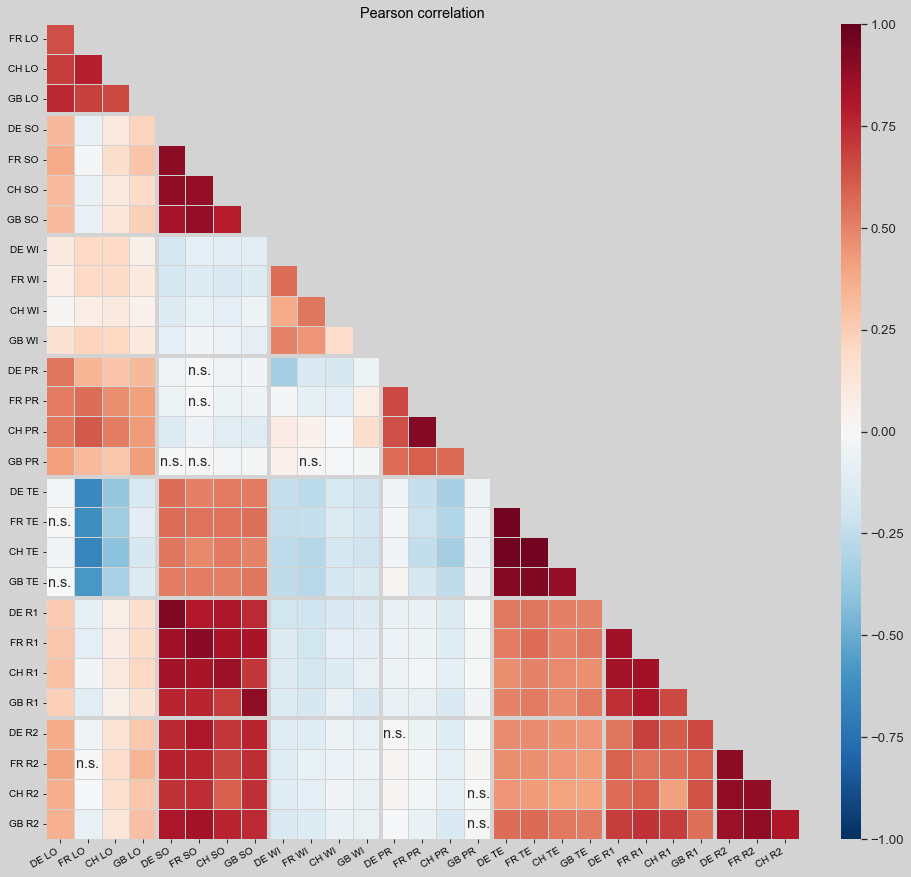

In [27]:
ticks=[labels_vars[var][0] for var in cols_for_corr]
df_corr = df[cols_for_corr].reset_index(drop=True)

def corr_sig(df, corr_type='pearson'):
    p_matrix = np.empty(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            if corr_type=='pearson':
                _ , p = stats.pearsonr(df[col],df[col2])
            elif corr_type=='spearman':
                _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col), df.columns.to_list().index(col2)] = p
    return p_matrix

p_values_p = corr_sig(df_corr, corr_type='pearson')
correlation_matrix_p = df_corr.corr(method='pearson').iloc[1:, :-1]
mask_unsig = 1
if '_all' in corr_file or annot:
    mask_unsig = 0.05
mask_p = np.invert(np.tril(p_values_p[1:, :-1]<=mask_unsig))#0.05))
mask_ns = np.invert(np.tril(p_values_p[1:, :-1]>0.05))
unsignificant_correlations = np.empty(shape=correlation_matrix_p.shape, dtype=object)
unsignificant_correlations[:] = 'n.s.'
color = cm.turbo(np.linspace(0, 1, len(vars_of_interest+vars_weather)))[::-1]
color = [(0.75*col+0.25*gray)/2 for col in color]
color = np.repeat(color, [4]*len(vars_predict),axis=0)

if show_figure:
    cmap = 'RdBu_r'
    if plot_all:
        fig, ax = plt.subplots(figsize=(15,15), facecolor=bg_color) 
    else:
        fig, ax = plt.subplots()#figsize=(15,15))        
        # ax = plt.axes()
    sns.set(font_scale=fs)
    
    dataplot = sns.heatmap(correlation_matrix_p, xticklabels=ticks[:-1], yticklabels=ticks[1:], 
                           mask=mask_p, 
                           annot=annot, 
                           cmap=cmap,
                           ax=ax,
                           cbar_kws={"fraction": frac, "aspect": asp},
                           linewidths=.5, #annot_kws={"size": 14},
                           linecolor=bg_color,
                           # row_km = [], column_km = 3,
                           vmin=-1, vmax=1, center=0
                          ).set_xticklabels(ticks[:-1], rotation=30, #labelsize=16,
                                            horizontalalignment='right')
    dataplot2 = sns.heatmap(correlation_matrix_p, xticklabels=ticks[:-1], yticklabels=ticks[1:], 
                           mask=mask_ns, 
                           annot=unsignificant_correlations, 
                           cmap=cmap,
                           # cmap=sns.color_palette(['lightgrey']),
                           ax=ax,
                           fmt="",
                           cbar=False,
                           linewidths=.5, #annot_kws={"size": 14},
                           linecolor=bg_color,
                            # row_km = 2, column_km = 3,
                           vmin=-1, vmax=1, center=0
                          ).set_xticklabels(ticks[:-1], rotation=30, #labelsize=16,
                                            horizontalalignment='right')
    
    # color = list(color)*len(prefixes)
    # for i, ticklabel in enumerate(dataplot.ax.xaxis.get_majorticklabels()):
    #     ticklabel.set_color(colors[i])
    print(len(ax.xaxis.get_ticklabels()))
    [t.set_color(color[int(i/2)]) for i, t in enumerate(ax.xaxis.get_ticklines()) if i%2==0]
    # [t.set_color(color[i+1]) for i, t in enumerate(ax.xaxis.get_ticklabels())]
    # ax.tick_params(axis='x', colors=color[:-1])
    # ax.tick_params(axis='y', colors=color[1:])
    ax.hlines([3, 7, 11, 15, 19, 23], *ax.get_xlim(), color=bg_color, lw=4)
    ax.vlines([4, 8, 12, 16, 20, 24], *ax.get_xlim(), color=bg_color, lw=4)
    #sns.set(font_scale=1.5)

    ax.set_title('Pearson correlation')
    ax.set_facecolor(bg_color)
    if save_figure:
        dpi = fig.get_dpi()
        plt.savefig("plots/"+corr_file+".jpg", bbox_inches='tight', dpi=dpi*dpi_factor)
    plt.show()

#### stationarity of time-series (via augmented Dickey-Fuller)

removing linear trends via differencing method

In [28]:
df_corr_diffs = df_corr.copy()
for i, col in enumerate(cols_for_corr):
    df_corr_diffs.loc[:, col+'_diff'] = np.append([0], np.diff(df_corr.loc[:,col]))

timedims = ['utc_timestamp', 'year', 'month', 'day', 'hour', 'weekday']

for timedim in timedims:
    df_corr_diffs[timedim] = df[timedim]

remove seasonality via advanced differencing with meaningful lags

only comment in if dickey-fuller turns out non-significant, then the ts would not be stationary, which is necessary for acd

In [29]:
remove_daily_patterns = False
remove_weekly_patterns = False
remove_yearly_patterns = False
# remove_daily_patterns = True
# remove_weekly_patterns = True
# remove_yearly_patterns = True

In [30]:
df_corr_diffs_copy = df_corr_diffs.copy()

if remove_daily_patterns:
    unique_hours = np.unique(df_corr_diffs['hour'])
    for i, col in enumerate(cols_for_corr):
        for hour in unique_hours:
            df_corr_diffs.loc[df_corr_diffs['hour']==hour, col+'_diff'] = np.append([0], np.diff(df_corr_diffs.loc[df_corr_diffs['hour']==hour,col+'_diff']))
    if not (remove_weekly_patterns & remove_yearly_patterns):
        df_corr_diffs_copy = df_corr_diffs.copy()
        df_corr_diffs = df_corr_diffs_copy.iloc[24:, :].reset_index()

if remove_weekly_patterns:
    unique_days = np.unique(df_corr_diffs['weekday'])
    for i, col in enumerate(cols_for_corr):
        for weekday in unique_days:
            df_corr_diffs.loc[df_corr_diffs['weekday']==weekday, col+'_diff'] = np.append([0], np.diff(df_corr_diffs.loc[df_corr_diffs['weekday']==weekday,col+'_diff']))
    if not remove_yearly_patterns:
        df_corr_diffs_copy = df_corr_diffs.copy()
        df_corr_diffs = df_corr_diffs_copy.iloc[24*7:, :].reset_index()

if remove_yearly_patterns:
    unique_months = np.unique(df_corr_diffs['month'])
    month_days = []
    for month in unique_months:
        unique_month_days = np.unique(df_corr_diffs.loc[df_corr_diffs['month']==month, 'day'])
        month_days += [unique_month_days]
    for i, col in enumerate(cols_for_corr):
        for month in unique_months:
            for month_day in month_days[month-1]:
                for hour in unique_hours:
                    cond = (df_corr_diffs['month']==month) & (df_corr_diffs['day']==month_day) & (df_corr_diffs['hour']==hour)
                    df_corr_diffs.loc[df_corr_diffs.index[cond], col+'_diff'] = np.append([0], np.diff(df_corr_diffs.loc[df_corr_diffs.index[cond], col+'_diff']))

calculate augmented dickey fuller test for statinarity (significant means stationary) both for original columns and differentiated columns

In [31]:
# test_dickeyfuller = False
# test_dickeyfuller = True
if test_dickeyfuller:
    for col in cols_for_corr:
        col_diff = col+'_diff'
        adfuller_test = adfuller(df_corr_diffs[col])
        adfuller_test_diff = adfuller(df_corr_diffs[col_diff])
        print(col + ' stationarity p-value: ', adfuller_test[1])
        print(col_diff + ' stationarity p-value: ', adfuller_test_diff[1])

DE_load_actual stationarity p-value:  0.0  
DE_load_actual_diff stationarity p-value:  0.0  
FR_load_actual stationarity p-value:  5.1853195341634805e-11  
FR_load_actual_diff stationarity p-value:  0.0  
CH_load_actual stationarity p-value:  7.671685660172501e-26  
CH_load_actual_diff stationarity p-value:  0.0  
GB_load_actual stationarity p-value:  7.749362657298042e-21  
GB_load_actual_diff stationarity p-value:  0.0    
DE_solar_generation stationarity p-value:  4.525053855036496e-13  
DE_solar_generation_diff stationarity p-value:  0.0  
FR_solar_generation stationarity p-value:  4.480294655460847e-12  
FR_solar_generation_diff stationarity p-value:  0.0  
CH_solar_generation stationarity p-value:  2.6668307740457695e-20  
CH_solar_generation_diff stationarity p-value:  0.0  
GB_solar_generation stationarity p-value:  3.1417443801121094e-17  
GB_solar_generation_diff stationarity p-value:  0.0  
DE_wind_generation stationarity p-value:  2.361086140226456e-28  
DE_wind_generation_diff stationarity p-value:  0.0  
FR_wind_generation stationarity p-value:  2.2250121892772773e-27  
FR_wind_generation_diff stationarity p-value:  0.0  
CH_wind_generation stationarity p-value:  3.60651028811071e-30  
CH_wind_generation_diff stationarity p-value:  0.0  
GB_wind_generation stationarity p-value:  6.155932405809737e-29  
GB_wind_generation_diff stationarity p-value:  0.0  
DE_price_day_ahead stationarity p-value:  9.420579126359643e-29  
DE_price_day_ahead_diff stationarity p-value:  0.0  
FR_price_day_ahead stationarity p-value:  3.788296512195511e-21  
FR_price_day_ahead_diff stationarity p-value:  0.0  
CH_price_day_ahead stationarity p-value:  2.3406177617074072e-17  
CH_price_day_ahead_diff stationarity p-value:  0.0  
GB_price_day_ahead stationarity p-value:  3.8233459616726083e-11  
GB_price_day_ahead_diff stationarity p-value:  0.0  
DE_temperature stationarity p-value:  3.119371938021788e-06  
DE_temperature_diff stationarity p-value:  0.0  
FR_temperature stationarity p-value:  1.98216517508444e-06  
FR_temperature_diff stationarity p-value:  0.0  
CH_temperature stationarity p-value:  7.028301558045168e-08  
CH_temperature_diff stationarity p-value:  0.0  
GB_temperature stationarity p-value:  1.2790998927570337e-08  
GB_temperature_diff stationarity p-value:  0.0  
DE_radiation_direct_horizontal stationarity p-value:  1.377671673503874e-22  
DE_radiation_direct_horizontal_diff stationarity p-value:  0.0  
FR_radiation_direct_horizontal stationarity p-value:  1.020651406839416e-20  
FR_radiation_direct_horizontal_diff stationarity p-value:  0.0  
CH_radiation_direct_horizontal stationarity p-value:  8.062526348194983e-29  
CH_radiation_direct_horizontal_diff stationarity p-value:  0.0  
GB_radiation_direct_horizontal stationarity p-value:  2.8157648997489074e-23  
GB_radiation_direct_horizontal_diff stationarity p-value:  0.0  
DE_radiation_diffuse_horizontal stationarity p-value:  1.0752338136597405e-17  
DE_radiation_diffuse_horizontal_diff stationarity p-value:  0.0  
FR_radiation_diffuse_horizontal stationarity p-value:  4.138121800454056e-21  
FR_radiation_diffuse_horizontal_diff stationarity p-value:  0.0  
CH_radiation_diffuse_horizontal stationarity p-value:  1.02783770999282e-24  
CH_radiation_diffuse_horizontal_diff stationarity p-value:  0.0  
GB_radiation_diffuse_horizontal stationarity p-value:  2.975166871293408e-13  
GB_radiation_diffuse_horizontal_diff stationarity p-value:  0.0  

#### plot stationary time-series

In [32]:
# #perfect settings for CH
# def plot_ts(df_plot, cols_to_plot=None, labels=None, 
#             plot_pred=True, plot_mean=True, plot_dif=False, 
#             datemin=[2015, 1, 1], datemax=[2020, 1, 1], 
#             color=None, legend_color=None,
#             bg_color='black', pred_color='white', 
#             legend_alpha=0.8, legend_text_alpha = 0.8,
#             gray_share = 0.25,
#             face_color=None, alpha_ts=1, alpha_pred=0.6,
#             avg_color=None, avg_pred_color='white', 
#             show_mean=False, time_unit='', do_set_fc=True,
#             fs=18, fig_width=20, subplot_height=1.5, 
#             save_figure=False, plot_name="plot_ts",
#             prefix='DE ',
#             annotate=False):
    
#     if cols_to_plot is None:
#         cols_to_plot = ['DE_load_actual'
#                 , 'DE_solar_generation' 
#                 , 'DE_wind_generation'
#                 , 'DE_price_day_ahead'
#                 , 'DE_temperature'
#                 , 'DE_radiation_direct_horizontal' 
#                 , 'DE_radiation_diffuse_horizontal'
#                ]
#     if labels is None:
#         labels = [('DE total load', '[GW]')
#           , ('DE solar generation', '[GW]')
#           , ('DE wind generation', '[GW]')
#           , ('DE price day-ahead', '[EUR]')
#           , ('DE temperature', '[°C]')
#           , ('DE radiation direct', '[W/m²]')
#           , ('DE radiation diffuse', '[W/m²]')
#           ]
    
#     nplots = len(cols_to_plot)
    
#     if color is None:
#         color = cm.turbo(np.linspace(0, 1, nplots))[::-1]
#         if legend_color is not None:
#             color = ['b' for c in color]
        
#     datemin = datetime.datetime(datemin[0], datemin[1], datemin[2], tzinfo=pytz.UTC)
#     datemax = datetime.datetime(datemax[0], datemax[1], datemax[2], tzinfo=pytz.UTC)

#     fig = plt.figure(figsize=(fig_width, subplot_height*nplots))
#     if face_color is not None:
#         fig.set_facecolor(face_color)

#     for i, col in enumerate(cols_to_plot):
#         ax = plt.subplot(nplots, 1, i+1)
#         if not plot_dif:
#             mean_string = ''
#             if plot_mean and show_mean:
#                 divide_by = 1
#                 if 'W]' in labels[i][1] and 'load' in labels[i][0]:
#                     divide_by = 1000
#                     labels[i]=('total load', '[MW]')
#                     ax.set_ylim(bottom=-1*1000, top=14*1000)
#                     if annotate:
#                         height=1.05
#                         ax.annotate('training set', 
#                                     # ' ',
#                                     xy=(0.3, height), 
#                                     xytext=(0.3, height), xycoords='axes fraction',
#                                     fontsize=fs, ha='center', va='bottom',
#                                     color=black,#darkorange,
#                                     bbox=dict(boxstyle='round', fc=white),
#                                    )
#                         ax.annotate('validation set', 
#                                     # ' ',
#                                     xy=(0.7, height), 
#                                     xytext=(0.7, height), xycoords='axes fraction',
#                                     fontsize=fs, ha='center', va='bottom',
#                                     color=black,#green,
#                                     bbox=dict(boxstyle='round', fc=white),
#                                    )
#                         ax.annotate('test set', 
#                                     # ' ',
#                                     xy=(0.9, height), 
#                                     xytext=(0.9, height), xycoords='axes fraction',
#                                     fontsize=fs, ha='center', va='bottom',
#                                     color=black,#dodgerblue,
#                                     bbox=dict(boxstyle='round', fc=white),
#                                    )
#                 elif 'W]' in labels[i][1] and 'solar generation' in labels[i][0]:
#                     divide_by = 1
#                     labels[i]=('solar generation', '[MW]')
#                     ax.set_ylim(bottom=-50, 
#                                 top=450)
#                 elif 'W]' in labels[i][1] and 'wind generation' in labels[i][0]:
#                     divide_by = 1
#                     labels[i]=('wind generation', '[MW]')
#                     ax.set_ylim(bottom=-5, 
#                                 top=75)
#                 elif 'W/' in labels[i][1]:
#                     ax.set_ylim(bottom=-20, top=980)
#                 elif 'C' in labels[i][1]:
#                     ax.set_ylim(bottom = -22 , top = 43)
#                 else:
#                     ax.set_ylim(bottom=-35, top=165)
#                 mean_to_plot = np.mean(df_plot[col])
#                 std_to_plot = np.std(df_plot[col])
#                 k = ''
#                 if mean_to_plot >= 1000:
#                     k = 'k'
#                     divide_by = 1000                    
#                 # mean_string = ', mean = '+str(np.round(np.mean(df_plot[col])/divide_by, 2))
#                 # mean_string = f', m = {round(mean_to_plot/divide_by, 1)}{k} $\pm$ {round(std_to_plot/divide_by, 1)}'
#                 mean_string = f', m = {round(mean_to_plot/divide_by, 1)}{k}, sd = {round(std_to_plot/divide_by, 1)}{k}'
#                 ax.plot(df_plot[col]
#                     , c=color[i]
#                     , alpha = alpha_ts
#                     , label=prefix+labels[i][0]+mean_string
#                    )
#             if plot_pred:
#                 if col+'_pred' in df_plot.columns:
#                     ax.plot(df_plot[col+'_pred']
#                             , c=pred_color
#                             , alpha = alpha_pred
#                            )
#             if plot_mean:
#                 if avg_color is None:
#                     ax.axhline(y=np.mean(df_plot[col])
#                                , c=(legend_color[i]+dimgray)/2
#                                , lw=2
#                               )
#                 else:
#                     ax.axhline(y=np.mean(df_plot[col])
#                                , c=avg_color
#                                , lw=2
#                               )    
#                 if plot_pred:
#                     if col+'_pred' in df_plot.columns:
#                         ax.axhline(y=np.mean(df_plot[col+'_pred'])
#                                    , c=avg_pred_color
#                                    , lw=2
#                                   )
#             # if annotate:
#             #     ax.axvline(pd.to_datetime('2018-01-01'), color=dimgray,#black,#darkorange,
#             #                linestyle='--', lw=1.5
#             #               )
#             #     ax.axvline(pd.to_datetime('2019-01-01'), color=dimgray,#black,#green, 
#             #                linestyle='--', lw=1.5
#             #               )   
#                 # ax.axvline(pd.to_datetime('2019-01-01'), color='seagreen', linestyle='--', lw=2)                
#         else:
#             ax.plot(df_plot[col] - df_plot[col+'_pred']
#                     , c=color[i]
#                     , alpha = 1#0.75
#                     , label=labels[i][0]
#                    )
#             if plot_mean:
#                 mean_to_plot = np.mean(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
#                 std_to_plot = np.std(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
#                 factor=1
#                 if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
#                     factor=1000
#                 ax.axhline(y=mean_to_plot
#                            , c=(color[i]+dimgray)/2
#                            , label=f', m = {round(mean_to_plot/factor, 1)} $\pm$ {round(std_to_plot/factor, 1)}'
#                           )
        
#         if do_set_fc:
#             ax.set_facecolor(color=bg_color)

#         ax.set_xlim(datemin, datemax)
#         ax.set_ylabel(labels[i][1], fontsize=fs)#, rotation=45)
#         ax.tick_params(axis='both', which='major', labelsize=fs)
#         if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
#             ticks_loc = ax.get_yticks()
#             ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#             if labels[i][1] == '[MW]':
#                 ax.set_yticklabels(['{}'.format(int(tick/1000))+'k' if int(tick)>1000 else '{}'.format(int(tick)) for tick in ticks_loc])
#             elif labels[i][1] == '[GW]':
#                 ax.set_yticklabels([str(int(tick)) for tick in ticks_loc/1000])

#         if i < nplots-1:
#             ax.xaxis.set_ticklabels([])
#         else:
#             ax.set_xlabel('time'+ time_unit, fontsize=fs)

#         leg = plt.legend(loc = "upper left", fontsize=fs, handletextpad=0, handlelength=0,
#                          # facecolor=legend_color[i], labelcolor='w')
#                          facecolor=(1-gray_share)*legend_color[i]+gray_share*gray, 
#                          labelcolor='w', 
#                          framealpha=legend_alpha
#                          )
#         for text in leg.get_texts():
#             text.set_alpha(legend_text_alpha)
            
#     fig.align_ylabels()
#     # fig.tight_layout()
#     plt.subplots_adjust(hspace=0.1)

#     factor=8
#     if save_figure:
#         dpi = fig.get_dpi()
#         plt.savefig("plots/"+plot_name+".jpg", bbox_inches='tight', dpi=dpi*factor)
#     plt.show()



In [33]:
# #perfect settings for DE
# def plot_ts(df_plot, cols_to_plot=None, labels=None, 
#             plot_pred=True, plot_mean=True, plot_dif=False, 
#             datemin=[2015, 1, 1], datemax=[2020, 1, 1], 
#             color=None, legend_color=None,
#             bg_color='black', pred_color='white', 
#             legend_alpha=0.8, legend_text_alpha = 0.8,
#             gray_share = 0.25,
#             face_color=None, alpha_ts=1, alpha_pred=0.6,
#             avg_color=None, avg_pred_color='white', 
#             show_mean=False, time_unit='', do_set_fc=True,
#             fs=18, fig_width=20, subplot_height=1.5, 
#             save_figure=False, plot_name="plot_ts",
#             prefix='DE ', linebreak = '',
#             annotate=False):
    
#     if cols_to_plot is None:
#         cols_to_plot = ['DE_load_actual'
#                 , 'DE_solar_generation' 
#                 , 'DE_wind_generation'
#                 , 'DE_price_day_ahead'
#                 , 'DE_temperature'
#                 , 'DE_radiation_direct_horizontal' 
#                 , 'DE_radiation_diffuse_horizontal'
#                ]
#     if labels is None:
#         labels = [('DE total load', '[GW]')
#           , ('DE solar generation', '[GW]')
#           , ('DE wind generation', '[GW]')
#           , ('DE price day-ahead', '[EUR]')
#           , ('DE temperature', '[°C]')
#           , ('DE radiation direct', '[W/m²]')
#           , ('DE radiation diffuse', '[W/m²]')
#           ]
    
#     nplots = len(cols_to_plot)
    
#     if color is None:
#         color = cm.turbo(np.linspace(0, 1, nplots))[::-1]
#         if legend_color is not None:
#             color = ['b' for c in color]
        
#     datemin = datetime.datetime(datemin[0], datemin[1], datemin[2], tzinfo=pytz.UTC)
#     datemax = datetime.datetime(datemax[0], datemax[1], datemax[2], tzinfo=pytz.UTC)

#     fig = plt.figure(figsize=(fig_width, subplot_height*nplots))
#     if face_color is not None:
#         fig.set_facecolor(face_color)

#     for i, col in enumerate(cols_to_plot):
#         ax = plt.subplot(nplots, 1, i+1)
#         if not plot_dif:
#             mean_string = ''
#             if plot_mean and show_mean:
#                 divide_by = 1
#                 if 'W]' in labels[i][1] and 'load' in labels[i][0]:
#                     divide_by = 1000
#                     ax.set_ylim(bottom=-7*1000, top=93*1000)
#                     if annotate:
#                         height=1.05
#                         ax.annotate('training set', 
#                                     # ' ',
#                                     xy=(0.3, height), 
#                                     xytext=(0.3, height), xycoords='axes fraction',
#                                     fontsize=fs, ha='center', va='bottom',
#                                     color=black,#darkorange,
#                                     bbox=dict(boxstyle='round', fc=white),
#                                    )
#                         ax.annotate('validation set', 
#                                     # ' ',
#                                     xy=(0.7, height), 
#                                     xytext=(0.7, height), xycoords='axes fraction',
#                                     fontsize=fs, ha='center', va='bottom',
#                                     color=black,#green,
#                                     bbox=dict(boxstyle='round', fc=white),
#                                    )
#                         ax.annotate('test set', 
#                                     # ' ',
#                                     xy=(0.9, height), 
#                                     xytext=(0.9, height), xycoords='axes fraction',
#                                     fontsize=fs, ha='center', va='bottom',
#                                     color=black,#dodgerblue,
#                                     bbox=dict(boxstyle='round', fc=white),
#                                    )
#                 elif 'W]' in labels[i][1] and 'generation' in labels[i][0]:
#                     divide_by = 1
#                     ax.set_ylim(bottom=-7*1000, 
#                                 top=93*1000)
#                 elif 'W/' in labels[i][1]:
#                     ax.set_ylim(bottom=-20, top=980)
#                 elif 'C' in labels[i][1]:
#                     ax.set_ylim(bottom = -22 , top = 43)
#                 else:
#                     ax.set_ylim(bottom=-35, top=165)
#                 mean_to_plot = np.mean(df_plot[col])
#                 std_to_plot = np.std(df_plot[col])
#                 k = ''
#                 if mean_to_plot >= 1000:
#                     k = ''
#                     divide_by = 1000                    
#                 # mean_string = ', mean = '+str(np.round(np.mean(df_plot[col])/divide_by, 2))
#                 # mean_string = f', m = {round(mean_to_plot/divide_by, 1)}{k} $\pm$ {round(std_to_plot/divide_by, 1)}'
#                 mean_string = f',{linebreak} m = {round(mean_to_plot/divide_by, 1)}{k}, sd = {round(std_to_plot/divide_by, 1)}{k}'
#                 ax.plot(df_plot[col]
#                     , c=color[i]
#                     , alpha = alpha_ts
#                     , label=prefix+labels[i][0]+mean_string
#                    )
#             if plot_pred:
#                 if col+'_pred' in df_plot.columns:
#                     ax.plot(df_plot[col+'_pred']
#                             , c=pred_color
#                             , alpha = alpha_pred
#                            )
#             if plot_mean:
#                 if avg_color is None:
#                     ax.axhline(y=np.mean(df_plot[col])
#                                , c=(legend_color[i]+dimgray)/2
#                                , lw=2
#                               )
#                 else:
#                     ax.axhline(y=np.mean(df_plot[col])
#                                , c=avg_color
#                                , lw=2
#                               )    
#                 if plot_pred:
#                     if col+'_pred' in df_plot.columns:
#                         ax.axhline(y=np.mean(df_plot[col+'_pred'])
#                                    , c=avg_pred_color
#                                    , lw=2
#                                   )
#             # if annotate:
#             #     ax.axvline(pd.to_datetime('2018-01-01'), color=dimgray,#black,#darkorange,
#             #                linestyle='--', lw=1.5
#             #               )
#             #     ax.axvline(pd.to_datetime('2019-01-01'), color=dimgray,#black,#green, 
#             #                linestyle='--', lw=1.5
#             #               )   
#                 # ax.axvline(pd.to_datetime('2019-01-01'), color='seagreen', linestyle='--', lw=2)                
#         else:
#             ax.plot(df_plot[col] - df_plot[col+'_pred']
#                     , c=color[i]
#                     , alpha = 1#0.75
#                     , label=labels[i][0]
#                    )
#             if plot_mean:
#                 mean_to_plot = np.mean(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
#                 std_to_plot = np.std(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
#                 factor=1
#                 if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
#                     factor=1000
#                 ax.axhline(y=mean_to_plot
#                            , c=(color[i]+dimgray)/2
#                            , label=f',{linebreak} m = {round(mean_to_plot/factor, 1)} $\pm$ {round(std_to_plot/factor, 1)}'
#                           )
        
#         if do_set_fc:
#             ax.set_facecolor(color=bg_color)

#         ax.set_xlim(datemin, datemax)
#         ax.set_ylabel(labels[i][1], fontsize=fs)#, rotation=45)
#         ax.tick_params(axis='both', which='major', labelsize=fs)
#         if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
#             ticks_loc = ax.get_yticks()
#             ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#             if labels[i][1] == '[MW]':
#                 ax.set_yticklabels(['{}'.format(int(tick/1000))+'k' if int(tick)>1000 else '{}'.format(int(tick)) for tick in ticks_loc])
#             elif labels[i][1] == '[GW]':
#                 ax.set_yticklabels([str(int(tick)) for tick in ticks_loc/1000])

#         if i < nplots-1:
#             ax.xaxis.set_ticklabels([])
#         else:
#             ax.set_xlabel('time'+ time_unit, fontsize=fs)

#         leg = plt.legend(loc = "upper left", fontsize=fs, handletextpad=0, handlelength=0,
#                          # facecolor=legend_color[i], labelcolor='w')
#                          facecolor=(1-gray_share)*legend_color[i]+gray_share*gray, 
#                          labelcolor='w', 
#                          framealpha=legend_alpha
#                          )
#         for text in leg.get_texts():
#             text.set_alpha(legend_text_alpha)
            
#     fig.align_ylabels()
#     # fig.tight_layout()
#     plt.subplots_adjust(hspace=0.1)

#     factor=8
#     if save_figure:
#         dpi = fig.get_dpi()
#         plt.savefig("plots/"+plot_name+".jpg", bbox_inches='tight', dpi=dpi*factor)
#     plt.show()



In [34]:
#perfect settings for FR
def plot_ts(df_plot, cols_to_plot=None, labels=None, 
            plot_pred=True, plot_mean=True, plot_dif=False, 
            datemin=[2015, 1, 1], datemax=[2020, 1, 1], 
            color=None, legend_color=None,
            bg_color='black', pred_color='white', 
            legend_alpha=0.8, legend_text_alpha = 0.8,
            gray_share = 0.25,
            face_color=None, alpha_ts=1, alpha_pred=0.6,
            avg_color=None, avg_pred_color='white', 
            show_mean=False, time_unit='', do_set_fc=True,
            fs=18, fig_width=20, subplot_height=1.5, 
            save_figure=False, plot_name="plot_ts",
            prefix='DE ', linebreak = '',
            annotate=False):
    
    if cols_to_plot is None:
        cols_to_plot = ['DE_load_actual'
                , 'DE_solar_generation' 
                , 'DE_wind_generation'
                , 'DE_price_day_ahead'
                , 'DE_temperature'
                , 'DE_radiation_direct_horizontal' 
                , 'DE_radiation_diffuse_horizontal'
               ]
    if labels is None:
        labels = [('DE total load', '[GW]')
          , ('DE solar generation', '[GW]')
          , ('DE wind generation', '[GW]')
          , ('DE price day-ahead', '[EUR]')
          , ('DE temperature', '[°C]')
          , ('DE radiation direct', '[W/m²]')
          , ('DE radiation diffuse', '[W/m²]')
          ]
    
    nplots = len(cols_to_plot)
    
    if color is None:
        color = cm.turbo(np.linspace(0, 1, nplots))[::-1]
        if legend_color is not None:
            color = ['b' for c in color]
        
    datemin = datetime.datetime(datemin[0], datemin[1], datemin[2], tzinfo=pytz.UTC)
    datemax = datetime.datetime(datemax[0], datemax[1], datemax[2], tzinfo=pytz.UTC)

    fig = plt.figure(figsize=(fig_width, subplot_height*nplots))
    if face_color is not None:
        fig.set_facecolor(face_color)

    for i, col in enumerate(cols_to_plot):
        ax = plt.subplot(nplots, 1, i+1)
        if not plot_dif:
            mean_string = ''
            if plot_mean and show_mean:
                divide_by = 1
                if 'W]' in labels[i][1] and 'load' in labels[i][0]:
                    divide_by = 1000
                    ax.set_ylim(bottom=-7*1000, top=113*1000)
                    if annotate:
                        height=1.05
                        ax.annotate('training set', 
                                    # ' ',
                                    xy=(0.3, height), 
                                    xytext=(0.3, height), xycoords='axes fraction',
                                    fontsize=fs, ha='center', va='bottom',
                                    color=black,#darkorange,
                                    bbox=dict(boxstyle='round', fc=white),
                                   )
                        ax.annotate('validation set', 
                                    # ' ',
                                    xy=(0.7, height), 
                                    xytext=(0.7, height), xycoords='axes fraction',
                                    fontsize=fs, ha='center', va='bottom',
                                    color=black,#green,
                                    bbox=dict(boxstyle='round', fc=white),
                                   )
                        ax.annotate('test set', 
                                    # ' ',
                                    xy=(0.9, height), 
                                    xytext=(0.9, height), xycoords='axes fraction',
                                    fontsize=fs, ha='center', va='bottom',
                                    color=black,#dodgerblue,
                                    bbox=dict(boxstyle='round', fc=white),
                                   )
                elif 'W]' in labels[i][1] and 'generation' in labels[i][0]:
                    divide_by = 1
                    ax.set_ylim(bottom=-2*1000, 
                                top=18*1000)
                elif 'W/' in labels[i][1]:
                    ax.set_ylim(bottom=-20, top=980)
                elif 'C' in labels[i][1]:
                    ax.set_ylim(bottom = -22 , top = 43)
                else:
                    ax.set_ylim(bottom=-35, top=165)
                mean_to_plot = np.mean(df_plot[col])
                std_to_plot = np.std(df_plot[col])
                k = ''
                if mean_to_plot >= 1000:
                    k = ''
                    divide_by = 1000                    
                # mean_string = ', mean = '+str(np.round(np.mean(df_plot[col])/divide_by, 2))
                # mean_string = f', m = {round(mean_to_plot/divide_by, 1)}{k} $\pm$ {round(std_to_plot/divide_by, 1)}'
                mean_string = f',{linebreak} m = {round(mean_to_plot/divide_by, 1)}{k}, sd = {round(std_to_plot/divide_by, 1)}{k}'
                ax.plot(df_plot[col]
                    , c=color[i]
                    , alpha = alpha_ts
                    , label=prefix+labels[i][0]+mean_string
                   )
            if plot_pred:
                if col+'_pred' in df_plot.columns:
                    ax.plot(df_plot[col+'_pred']
                            , c=pred_color
                            , alpha = alpha_pred
                           )
            if plot_mean:
                if avg_color is None:
                    ax.axhline(y=np.mean(df_plot[col])
                               , c=(legend_color[i]+dimgray)/2
                               , lw=2
                              )
                else:
                    ax.axhline(y=np.mean(df_plot[col])
                               , c=avg_color
                               , lw=2
                              )    
                if plot_pred:
                    if col+'_pred' in df_plot.columns:
                        ax.axhline(y=np.mean(df_plot[col+'_pred'])
                                   , c=avg_pred_color
                                   , lw=2
                                  )
            # if annotate:
            #     ax.axvline(pd.to_datetime('2018-01-01'), color=dimgray,#black,#darkorange,
            #                linestyle='--', lw=1.5
            #               )
            #     ax.axvline(pd.to_datetime('2019-01-01'), color=dimgray,#black,#green, 
            #                linestyle='--', lw=1.5
            #               )   
                # ax.axvline(pd.to_datetime('2019-01-01'), color='seagreen', linestyle='--', lw=2)                
        else:
            ax.plot(df_plot[col] - df_plot[col+'_pred']
                    , c=color[i]
                    , alpha = 1#0.75
                    , label=labels[i][0]
                   )
            if plot_mean:
                mean_to_plot = np.mean(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
                std_to_plot = np.std(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
                factor=1
                if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
                    factor=1000
                ax.axhline(y=mean_to_plot
                           , c=(color[i]+dimgray)/2
                           , label=f',{linebreak} m = {round(mean_to_plot/factor, 1)} $\pm$ {round(std_to_plot/factor, 1)}'
                          )
        
        if do_set_fc:
            ax.set_facecolor(color=bg_color)

        ax.set_xlim(datemin, datemax)
        ax.set_ylabel(labels[i][1], fontsize=fs)#, rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
            ticks_loc = ax.get_yticks()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            if labels[i][1] == '[MW]':
                ax.set_yticklabels(['{}'.format(int(tick/1000))+'k' if int(tick)>1000 else '{}'.format(int(tick)) for tick in ticks_loc])
            elif labels[i][1] == '[GW]':
                ax.set_yticklabels([str(int(tick)) for tick in ticks_loc/1000])

        if i < nplots-1:
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('time'+ time_unit, fontsize=fs)

        leg = plt.legend(loc = "upper left", fontsize=fs, handletextpad=0, handlelength=0,
                         # facecolor=legend_color[i], labelcolor='w')
                         facecolor=(1-gray_share)*legend_color[i]+gray_share*gray, 
                         labelcolor='w', 
                         framealpha=legend_alpha
                         )
        for text in leg.get_texts():
            text.set_alpha(legend_text_alpha)
            
    fig.align_ylabels()
    # fig.tight_layout()
    plt.subplots_adjust(hspace=0.1)

    factor=8
    if save_figure:
        dpi = fig.get_dpi()
        plt.savefig("plots/"+plot_name+".jpg", bbox_inches='tight', dpi=dpi*factor)
    plt.show()



In [35]:
#perfect settings for GB
def plot_ts(df_plot, cols_to_plot=None, labels=None, 
            plot_pred=True, plot_mean=True, plot_dif=False, 
            datemin=[2015, 1, 1], datemax=[2020, 1, 1], 
            color=None, legend_color=None,
            bg_color='black', pred_color='white', 
            legend_alpha=0.8, legend_text_alpha = 0.8,
            gray_share = 0.25,
            face_color=None, alpha_ts=1, alpha_pred=0.6,
            avg_color=None, avg_pred_color='white', 
            show_mean=False, time_unit='', do_set_fc=True,
            fs=18, fig_width=20, subplot_height=1.5, 
            save_figure=False, plot_name="plot_ts",
            prefix='DE ', linebreak = '',
            annotate=False):
    
    if cols_to_plot is None:
        cols_to_plot = ['DE_load_actual'
                , 'DE_solar_generation' 
                , 'DE_wind_generation'
                , 'DE_price_day_ahead'
                , 'DE_temperature'
                , 'DE_radiation_direct_horizontal' 
                , 'DE_radiation_diffuse_horizontal'
               ]
    if labels is None:
        labels = [('DE total load', '[GW]')
          , ('DE solar generation', '[GW]')
          , ('DE wind generation', '[GW]')
          , ('DE price day-ahead', '[EUR]')
          , ('DE temperature', '[°C]')
          , ('DE radiation direct', '[W/m²]')
          , ('DE radiation diffuse', '[W/m²]')
          ]
    
    nplots = len(cols_to_plot)
    
    if color is None:
        color = cm.turbo(np.linspace(0, 1, nplots))[::-1]
        if legend_color is not None:
            color = ['b' for c in color]
        
    datemin = datetime.datetime(datemin[0], datemin[1], datemin[2], tzinfo=pytz.UTC)
    datemax = datetime.datetime(datemax[0], datemax[1], datemax[2], tzinfo=pytz.UTC)

    fig = plt.figure(figsize=(fig_width, subplot_height*nplots))
    if face_color is not None:
        fig.set_facecolor(face_color)

    for i, col in enumerate(cols_to_plot):
        ax = plt.subplot(nplots, 1, i+1)
        if not plot_dif:
            mean_string = ''
            if plot_mean and show_mean:
                divide_by = 1
                if 'W]' in labels[i][1] and 'load' in labels[i][0]:
                    divide_by = 1000
                    ax.set_ylim(bottom=-7*1000, top=93*1000)
                    if annotate:
                        height=1.05
                        ax.annotate('training set', 
                                    # ' ',
                                    xy=(0.3, height), 
                                    xytext=(0.3, height), xycoords='axes fraction',
                                    fontsize=fs, ha='center', va='bottom',
                                    color=black,#darkorange,
                                    bbox=dict(boxstyle='round', fc=white),
                                   )
                        ax.annotate('validation set', 
                                    # ' ',
                                    xy=(0.7, height), 
                                    xytext=(0.7, height), xycoords='axes fraction',
                                    fontsize=fs, ha='center', va='bottom',
                                    color=black,#green,
                                    bbox=dict(boxstyle='round', fc=white),
                                   )
                        ax.annotate('test set', 
                                    # ' ',
                                    xy=(0.9, height), 
                                    xytext=(0.9, height), xycoords='axes fraction',
                                    fontsize=fs, ha='center', va='bottom',
                                    color=black,#dodgerblue,
                                    bbox=dict(boxstyle='round', fc=white),
                                   )
                elif 'W]' in labels[i][1] and 'generation' in labels[i][0]:
                    divide_by = 1
                    ax.set_ylim(bottom=-2*1000, 
                                top=18*1000)
                elif 'W/' in labels[i][1]:
                    ax.set_ylim(bottom=-20, top=980)
                elif 'C' in labels[i][1]:
                    ax.set_ylim(bottom = -22 , top = 43)
                else:
                    labels[i] = (' price day-ahead', '[GBP]')
                    ax.set_ylim(bottom=-35, top=165)
                mean_to_plot = np.mean(df_plot[col])
                std_to_plot = np.std(df_plot[col])
                k = ''
                if mean_to_plot >= 1000:
                    k = ''
                    divide_by = 1000                    
                # mean_string = ', mean = '+str(np.round(np.mean(df_plot[col])/divide_by, 2))
                # mean_string = f', m = {round(mean_to_plot/divide_by, 1)}{k} $\pm$ {round(std_to_plot/divide_by, 1)}'
                mean_string = f',{linebreak} m = {round(mean_to_plot/divide_by, 1)}{k}, sd = {round(std_to_plot/divide_by, 1)}{k}'
                ax.plot(df_plot[col]
                    , c=color[i]
                    , alpha = alpha_ts
                    , label=prefix+labels[i][0]+mean_string
                   )
            if plot_pred:
                if col+'_pred' in df_plot.columns:
                    ax.plot(df_plot[col+'_pred']
                            , c=pred_color
                            , alpha = alpha_pred
                           )
            if plot_mean:
                if avg_color is None:
                    ax.axhline(y=np.mean(df_plot[col])
                               , c=(legend_color[i]+dimgray)/2
                               , lw=2
                              )
                else:
                    ax.axhline(y=np.mean(df_plot[col])
                               , c=avg_color
                               , lw=2
                              )    
                if plot_pred:
                    if col+'_pred' in df_plot.columns:
                        ax.axhline(y=np.mean(df_plot[col+'_pred'])
                                   , c=avg_pred_color
                                   , lw=2
                                  )
            # if annotate:
            #     ax.axvline(pd.to_datetime('2018-01-01'), color=dimgray,#black,#darkorange,
            #                linestyle='--', lw=1.5
            #               )
            #     ax.axvline(pd.to_datetime('2019-01-01'), color=dimgray,#black,#green, 
            #                linestyle='--', lw=1.5
            #               )   
                # ax.axvline(pd.to_datetime('2019-01-01'), color='seagreen', linestyle='--', lw=2)                
        else:
            ax.plot(df_plot[col] - df_plot[col+'_pred']
                    , c=color[i]
                    , alpha = 1#0.75
                    , label=labels[i][0]
                   )
            if plot_mean:
                mean_to_plot = np.mean(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
                std_to_plot = np.std(df_plot.loc[datemin:datemax][col]-df_plot.loc[datemin:datemax][col+'_pred'])
                factor=1
                if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
                    factor=1000
                ax.axhline(y=mean_to_plot
                           , c=(color[i]+dimgray)/2
                           , label=f',{linebreak} m = {round(mean_to_plot/factor, 1)} $\pm$ {round(std_to_plot/factor, 1)}'
                          )
        
        if do_set_fc:
            ax.set_facecolor(color=bg_color)

        ax.set_xlim(datemin, datemax)
        ax.set_ylabel(labels[i][1], fontsize=fs)#, rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
            ticks_loc = ax.get_yticks()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            if labels[i][1] == '[MW]':
                ax.set_yticklabels(['{}'.format(int(tick/1000))+'k' if int(tick)>1000 else '{}'.format(int(tick)) for tick in ticks_loc])
            elif labels[i][1] == '[GW]':
                ax.set_yticklabels([str(int(tick)) for tick in ticks_loc/1000])

        if i < nplots-1:
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('time'+ time_unit, fontsize=fs)

        leg = plt.legend(loc = "upper left", fontsize=fs, handletextpad=0, handlelength=0,
                         # facecolor=legend_color[i], labelcolor='w')
                         facecolor=(1-gray_share)*legend_color[i]+gray_share*gray, 
                         labelcolor='w', 
                         framealpha=legend_alpha
                         )
        for text in leg.get_texts():
            text.set_alpha(legend_text_alpha)
            
    fig.align_ylabels()
    # fig.tight_layout()
    plt.subplots_adjust(hspace=0.1)

    factor=8
    if save_figure:
        dpi = fig.get_dpi()
        plt.savefig("plots/"+plot_name+".jpg", bbox_inches='tight', dpi=dpi*factor)
    plt.show()



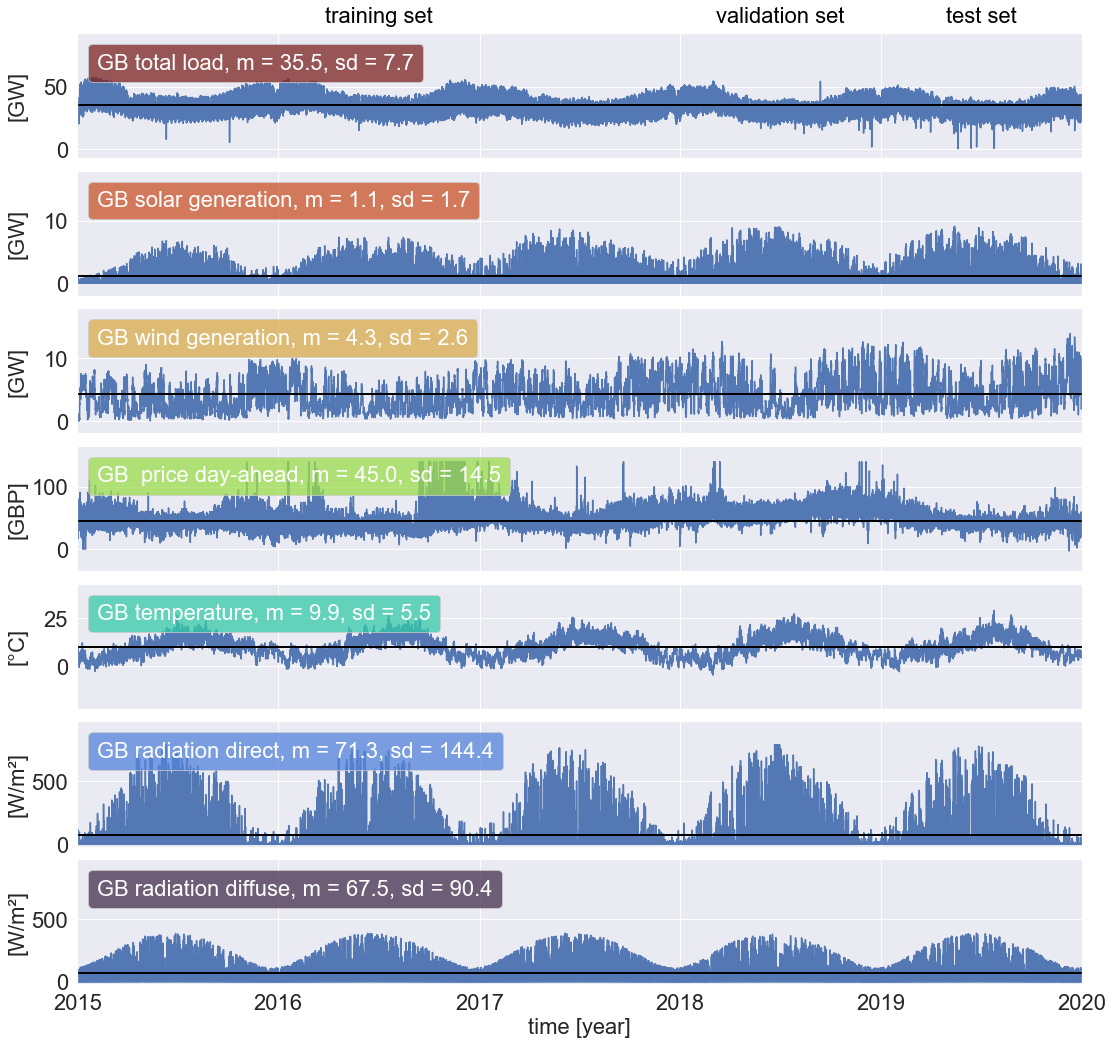

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
cols_to_plot_DE = ['DE_load_actual'
                   , 'DE_solar_generation' 
                   , 'DE_wind_generation'
                   , 'DE_price_day_ahead'
                   , 'DE_temperature'
                   , 'DE_radiation_direct_horizontal' 
                   , 'DE_radiation_diffuse_horizontal'
                   ]

labels_long = [('total load', '[GW]')
          , ('solar generation', '[GW]')
          , ('wind generation', '[GW]')
          , ('price day-ahead', '[EUR]')
          , ('temperature', '[°C]')
          , ('radiation direct', '[W/m²]')
          , ('radiation diffuse', '[W/m²]')
          ]
                
color = cm.turbo(np.linspace(0, 1, len(vars_of_interest+vars_weather)))[::-1]
color = list(color)*len(prefixes)

cols_to_plot = ['GB_'+var for var in vars_predict]
labels = labels_long

if set(cols_to_plot) == set(all_vars_of_interest_varfirst):
    labels_vars = labels_vars_short
else:
    labels_vars = labels_vars_long


bg_color_error=white

df_plot = df.set_index('utc_timestamp')

plot_name_base = "plot_ts"
datemin=[2015, 1, 1]
datemax=[2020, 1, 1]
# datemin=[2016, 2, 1]
# datemax=[2016, 3, 1]

# save_figure=True
# save_figure=False
plot_name=plot_name_base+'-colourIDGB'
if show_figure:
    plot_ts(df_plot, cols_to_plot=cols_to_plot, labels=labels, 
            color=None, 
            prefix='GB ',
            linebreak='',#'\n',
            legend_color = color,
            legend_alpha = 0.75,
            legend_text_alpha = 1,
            gray_share=0.25,#0.25,
            plot_pred=False, 
            datemin=datemin, datemax=datemax, 
            bg_color=lightgray, 
            alpha_ts=0.95, 
            avg_color=black,#darkdimgray,
            save_figure=save_figure, plot_name=plot_name,
            show_mean=True, time_unit=' [year]', do_set_fc=False,
            fs=22, fig_width=18, subplot_height=2.5,
            annotate=True
            )

In [37]:
df_plot = df_corr_diffs_copy.set_index('utc_timestamp')
# print(len(df_plot))
plot_name_base = "plot_ts"

datemin=[2016, 1, 1]
datemax=[2018, 1, 1]
# datemin=[2016, 2, 1]
# datemax=[2016, 6, 1]

cols = cols_to_plot

labels = [labels_vars[var] for var in cols]

plot_name=plot_name_base+'_corr'
if show_figure:
    plot_ts(df_plot, cols_to_plot=[col+'_diff' for col in cols], labels=labels, 
                legend_color=color,
                plot_pred=False, 
                datemin=datemin, datemax=datemax, 
                bg_color=white, alpha_ts=0.95, avg_color=dimgray,
                save_figure=False, plot_name=plot_name)
